<a name="top" id="top"></a>

<div align="center">
    <h1>CHE597 - Parameter Estimation </h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/PU_CHE597_S2025/blob/main/11-Parameter_Estimation/Parameter_Estimation.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameter-Estimation" data-toc-modified-id="Parameter-Estimation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameter Estimation</a></span><ul class="toc-item"><li><span><a href="#Analytic-Model" data-toc-modified-id="Analytic-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Analytic Model</a></span></li><li><span><a href="#Bootstrap-Analysis" data-toc-modified-id="Bootstrap-Analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Bootstrap Analysis</a></span></li><li><span><a href="#Bayesian-Inference" data-toc-modified-id="Bayesian-Inference-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Bayesian Inference</a></span></li></ul></li></ul></div>

In [ ]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


<b>If you are using google colab you should save this notebook and any associated textfiles to their own folder on your google drive. Then you will need to adapt the following commands so that the notebook runs from the location of that folder.</b>

In [ ]:
# If you want to use Google Drive to save/load files, set this to True
USE_GOOGLE_DRIVE = False
if IN_COLAB and USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

    # Colab command to navigate to the folder holding the homework,
    # CHANGE FOR YOUR SPECIFIC FOLDER LOCATION IN GOOGLE DRIVE
    # Note: if there are spaces in the path, you need to precede them with a backslash '\'
    %cd /content/drive/My\ Drive/CHE597/Lectures/9-Estimation

In [2]:
# Preliminary imports. random module will be used for shuffling lists
import matplotlib.pyplot as plt
import numpy as np
import random

## Parameter Estimation
In the last couple of lectures we've covered gradient based optimization algorithms in the context of parameterizing models. The output of our optimizers have been a single set of model parameters ($\beta$), which lead to a single set of predictions ($y_{p}$). Up until this point we haven't discussed uncertainty in $\beta$ or $y_{p}$. This is where <b>parameter estimation</b> comes in. 

<b>Parameter estimation</b> is the subfield of statistics concerned with estimating parameters and their uncertainties based on data. This has overlap with optimization (see Venn diagram in the lecture notes) and so the boundary between estimation and optimization is often fuzzy in practice. 

For our purposes, I will cover two methods for estimating parameter uncertainty. The first is called "<b>Bootstrap Analysis</b>". It is extremely general, makes no assumptions on the underlying data distribution, and can be applied to nearly any kind of model. The second is <b>Bayesian Inference</b> with Markov Chain Monte Carlo (MCMC) sampling of the posterior. This approach is requires you to make very specific assumptions about the underlying data distribution, but provides a rigorous approach to getting parameters and uncertainties under these assumptions. 

### Analytic Model
Before covering our methods for estimating parameter uncertainty and prediction uncertainty, let's load the dataset that we will use and present the standard analytic treatment. The `data.txt` file holds some data for the concentration of a reactant vs the impurity in the product for an unspecified chemical conversion:

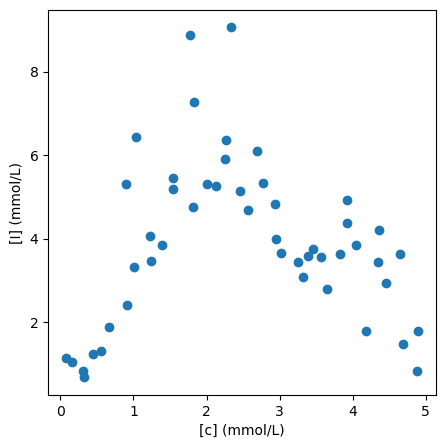

In [3]:
# Load data
data = np.loadtxt("data.txt",skiprows=1)
x = data[:,0]
y = data[:,1]

# Plot data
plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.xlabel("[c] (mmol/L)")
plt.ylabel("[I] (mmol/L)")
plt.show()

Our dataset is clearly non-linear. For our model we will use a polynomial fit. Basic polynomials are not linearly independent, so we will use a linear regression of Legendre polynomials (linear combinations of polynomials defined to be achieve orthogonality) for our model:

$$ \mathbf{y}_\mathrm{p} = \sum_{i=0}^{5} \beta_\mathrm{i} P_\mathrm{i}(\mathbf{x}) $$

where, $P_i$ are the Legendre polynomials up to order 5, and $\beta_\mathrm{i}$ are constants to be determined. Since the model is linear in $\boldsymbol{\beta}$ we can analytically determine the parameters:

$$ \mathbf{A}\boldsymbol{\beta} = \mathbf{y} \rightarrow \mathbf{A}^\mathrm{T} \mathbf{A} \boldsymbol{\beta} = \mathbf{A}^\mathrm{T} \boldsymbol{\beta}$$
where
$$\mathbf{A} = \begin{bmatrix} 
  P_0(x_1) & P_1(x_1) & ... & P_5(x_1) \\
  ... & ... & ...  & ... \\
  P_0(x_N) & P_1(x_N) & ... & P_5(x_N) 
  \end{bmatrix} \,\,\, \boldsymbol{\beta}= \begin{bmatrix} 
  \beta_0 \\
  \beta_1 \\
  ... \\
  \beta_5
  \end{bmatrix} \,\,\, \mathbf{y}= \begin{bmatrix} 
  y_0 \\
  y_1 \\
  ... \\
  y_N
  \end{bmatrix}$$

  <b>Note:</b> the Legendre polynomials are orthogonal on the domain [-1,1] so the x values in the dataset (0,5) need to be shifted and scaled to this domain (-2.5 and divided by 2.5).

  For a linear model and assuming that the errors are normally distributed, we can analytically solve for the standard error in parameters ($\mathrm{se}[\boldsymbol{\beta}]$) and in the predictions ($\mathrm{se}[\mathbf{y}_p]$):

  $$ \mathrm{se}\left(\boldsymbol{\beta}\right) = \mathrm{diag}\left[\left(\mathbf{A}^\mathrm{T}\mathbf{A}\right)^\mathrm{-1}\right]^\frac{1}{2}\sigma\,\,\,;\,\,\, \mathrm{se}\left(\mathbf{y}_i\right) = \left[\mathbf{P}(x_i)^\mathrm{T}\left(\mathbf{A}^\mathrm{T}\mathbf{A}\right)^\mathrm{-1}\mathbf{P}(x_i) \right]^\frac{1}{2}\sigma$$

  where $\mathbf{P}(x_i)$ is the vector containing the Legendre functions evaluated at each sample and $\sigma^2 = \frac{1}{N}\sum_\mathrm{i}^N\left(y_\mathrm{i}-y_\mathrm{p,i}\right)^2$. More generally the expression for the prediction interval can be obtained by substituting the desired percentile from the inverse of the cumulative Student's distribution for $\sigma$ in the above expressions (e.g., $t_{\alpha/2,dof}=1.96$ for a 95% confidence interval when N is large). Consult your favorite statistics textbook for more on analytic treatments, our focus here on is on more general approaches to estimation that work for non-linear models and error distributions that aren't necessarily Gaussian.  



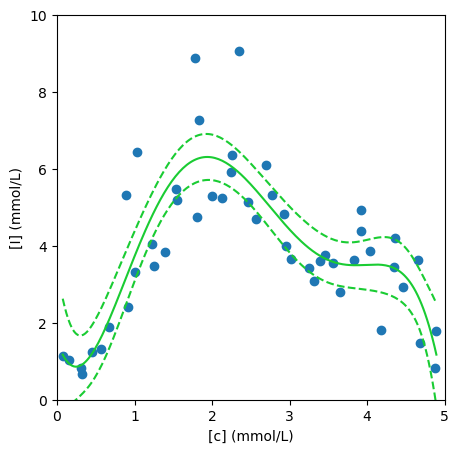

final parameters:   [ 3.84905187  0.03920449 -3.29598178  1.20751147  0.25342028 -1.97215615]
parameter s.e:      [0.15514951 0.27356462 0.35338119 0.42135195 0.48458079 0.55418314]


In [4]:
# Calculate best fit parameters
x_p = (x-2.5)/2.5 # Need to shift for Legendre polynomial
A = np.vstack([(x_p*0+1),x_p,0.5*(3.0*x_p**(2.0)-1.0),0.5*(5.0*x_p**(3.0)-3.0*x_p),1.0/8.0*(35.0*x_p**(4.0)-30.0*x_p**(2.0)+3.0),1.0/8.0*(63.0*x_p**(5.0)-70.0*x_p**(3.0)+15.0*x_p)]).T
params = np.linalg.solve(A.T@A,A.T@y)

# Calculate variance in residuals
var = np.mean((y-np.polynomial.legendre.legval(x_p,params))**(2.0))

# Calculate se in parameters
ATAi = np.linalg.inv(A.T@A)
var_B = np.diag(ATAi)**(0.5)*var

# Calculate se in predictions
x_plot = np.linspace(min(x),max(x),200)
se = []
for i in x_plot:
  i = (i-2.5)/2.5
  h = np.array([(i*0+1),i,0.5*(3.0*i**(2.0)-1.0),0.5*(5.0*i**(3.0)-3.0*i),1.0/8.0*(35.0*i**(4.0)-30.0*i**(2.0)+3.0),1.0/8.0*(63.0*i**(5.0)-70.0*i**(3.0)+15.0*i)])
  se += [(h@ATAi@h.T)**(0.5)*var**(0.5)]
se = np.array(se)

# Make a plot of the solution with prediction bounds
plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.plot(x_plot,np.polynomial.legendre.legval((x_plot-2.5)/2.5,params),color=(0.1,0.8,0.2))
plt.plot(x_plot,np.polynomial.legendre.legval((x_plot-2.5)/2.5,params)+se*1.96,linestyle='--',color=(0.1,0.8,0.2)) # scaled by 1.96 for 95% confidence interval
plt.plot(x_plot,np.polynomial.legendre.legval((x_plot-2.5)/2.5,params)-se*1.96,linestyle='--',color=(0.1,0.8,0.2)) # scaled by 1.96 for 95% confidence interval
plt.xlabel("[c] (mmol/L)")
plt.ylabel("[I] (mmol/L)")
plt.ylim([0,10])
plt.xlim([0,5])
plt.show()

# Print diagnostics
print("final parameters:   {}".format(params))
print("parameter s.e:      {}".format(var_B))

We have calculated the best model, the standard error in model parameters, and plotted the results with 95% prediction bounds using the standard analytic formulae and assuming gaussian statistics. A few things are worth noting. First, the parameter uncertainties increase for the higher order Legendre terms. This is consistent with our expectations that adding more polynomials will eventually result in overfitting. We can also see that the assumption of gaussian statistics results in symmetric prediction bounds (+/- the same amount with respect to the central line). This is something we have imposed on the dataset, not something that the data itself necessarily implies. We could analyze the residuals to try and justify the Gaussian assumption, but I won't do this here since the current results are primarily presented as a baseline for comparison with the bootstrap approach and Bayesian inference.

### Bootstrap Analysis
Let's pretend for a moment that we had 10x the data for the current problem. Maybe this data came from running the same series of experiments in parallel, so that we had 10 datasets over the same conditions, with each distinguished only by the stochastic factors in the measurements. With this larger dataset, how might we estimate uncertainties in our parameters and predictions? An obvious approach would be to train 10 separate models on the 10 datasets and then calculate the parameter variance accross these models. Likewise, we could estimate our prediction uncertainty based on the variance in predictions across these models. 

This approach would be great <i>if</i> we had 10 times more data than we do. The idea behind bootstrap analysis is that we can actually simulate having 10 times more data (or 1000 times more data) by randomly resampling our dataset with replacement. Specifically, what we want are new datasets that follow the distribution of the population, but 1) we don't know the population distribution, we just have a sample, and 2) we don't want to make any assumptions (like gaussian statistics) in order to generate these new datasets. When we resample with replacement we basically pretend that our population distribution consists of an infinite number of duplicates of our sample. Sampling this distribution yields new datasets that can be used to parameterize separate models and calculate parameter and prediction uncertainties. Critically, boostrapping does not make any assumption about the form of the underlying population distribution. The only assumption is that the sample is representative of the population distribution (which is the same assumption that all of our modeling is based on).   

So let's summarize the actual approach: (1) You have a sample dataset consisting of N data; (2) you take this dataset and (re)sample N data from it at random and <i>with replacement</i> (i.e., some values will be repeated and outliers won't show up in every sample); (3) You repeat this resampling n times and parameterize models to these n distinct datasets. After this you will have n models, trained on the n resampled datasets. You can estimate parameter uncertainties based on the parameter variances. You can also obtain prediction intervals by taking the predictions at the appropriate percentile across the models (e.g., if n=1000, you would take the $y_p$ for the models with the 50th and 950th largest values at a given $x_i$ and these would be your 5% and 95% prediction intervals for that $x_i$.)

Bootstrap analysis is conceptually similar to calculating errors using a validation dataset or with cross-validation. When we have a validation dataset, we can report a model error with respect to perforance on this witheld data. In bootstrap analysis, we generate pseudo validation sets by resampling the original dataset with replacement and retraining the model. Operationally it is very similar.  

First let's define a `boot` function which will be responsible for the resampling:

In [5]:
# bootstrap function
# assumes data is a list of arrays (e.g., data=[x,y])
def boot(data,samples=1000):
  N = len(data[0])
  for i in range(samples):
    inds = np.random.randint(0,N,size=N)
    yield [ j[inds] for j in data ]

Here we have used the `yield` keyword in order to avoid holding all of the distinct datasets in memory at the same time. `yield` is like a temporary `return` and allow the function to be used like any other iterable. 

Bootstrap analysis is compatible with any parameterization method. We could use it with the analytic solution, or we can use any of the gradient based methods that we have covered. Since we will typically retrain the models thousands of times, you wouldn't typically use bootstrap with a very expensive model. 

Here we will use the numpy `np.polynomial.legendre.legfit` function to do our fitting. It is equivalent to the analytic solution above, but it builds the `A` matrix for us behind the scenes. Let's use bootstrap resampling for `n=10000` to estimate the parameters and prediction intervals:

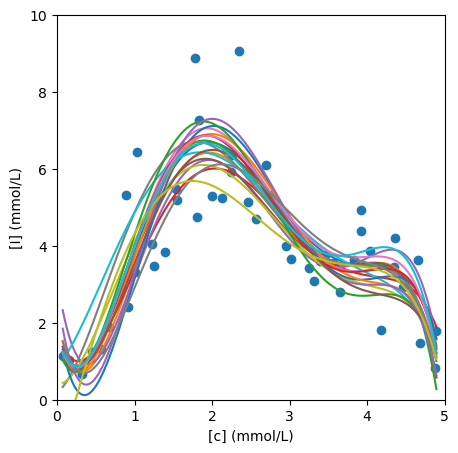

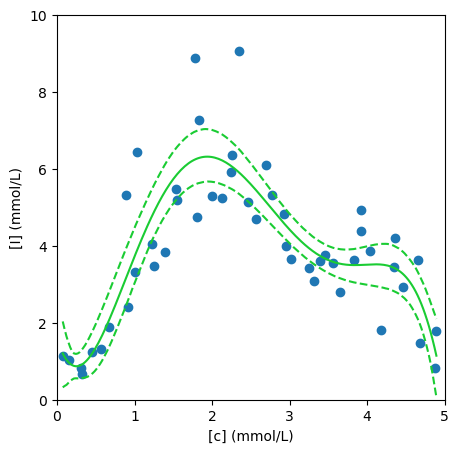

final parameters:   [ 3.85048788  0.03305684 -3.29983985  1.19334814  0.25567013 -1.99466229]
parameter s.e:      [0.16046176 0.25908299 0.33702189 0.44445976 0.55736779 0.5427481 ]


In [6]:
# Train 10000 models using bootstrap resampling
p = []   # holds the parameters for each model
y_p = [] # holds the predictions for each model
for i,j in boot([x_p,y],samples=10000):
  p += [np.polynomial.legendre.legfit(i,j,5)]
  y_p += [np.polynomial.legendre.legval((x_plot-2.5)/2.5,p[-1])] # note x rescaling for [-1,1] domain

# Convert the parameters and predictions to arrays
p = np.array(p)
y_p = np.array(y_p)

# Plot first 20 fits
plt.figure(figsize=(5,5))
plt.scatter(x,y)
for i in range(20):
  plt.plot(x_plot,y_p[i,:])
plt.xlabel("[c] (mmol/L)")
plt.ylabel("[I] (mmol/L)")
plt.ylim([0,10])
plt.xlim([0,5])
plt.show()

# Plot average model and prediction intervals
y_sorted = np.sort(y_p,axis=0)
plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.plot(x_plot,np.polynomial.legendre.legval((x_plot-2.5)/2.5,np.mean(p,axis=0)),color=(0.1,0.8,0.2))
plt.plot(x_plot,y_sorted[499,:],linestyle='--',color=(0.1,0.8,0.2)) # 5% for 10000 models
plt.plot(x_plot,y_sorted[9500,:],linestyle='--',color=(0.1,0.8,0.2)) # 95% for 10000 models
plt.xlabel("[c] (mmol/L)")
plt.ylabel("[I] (mmol/L)")
plt.ylim([0,10])
plt.xlim([0,5])
plt.show()

# Print diagnostics
print("final parameters:   {}".format(np.mean(p,axis=0)))
print("parameter s.e:      {}".format(np.std(p,axis=0)))

The first plot shows the predictions for the first 20 models that were trained by bootstrap resampling. You can see a large range of results, which is caused by the differences in training data for each model. In particular, we can see that there is relatively more uncertainty associated with the predictions in the central hump (x\~2) and near the start and finish (x\~0 and x\~5). 

The second plot shows the predictions of the average model and the 95% prediction bounds based on bootstrap analysis. First, note that using the average parameters only makes sense for a linear model--for a non-linear model you would use the model trained on the original sample. Second, we can see that the prediction bounds are quantitatively very similar to what was obtained from the analytic result, but there are some significant differences. The analytic result assumed normally distributed errors, and resulted in symmetric prediction bounds (i.e., +/- the same value). For the bootstrap analysis no such assumption is made, and if you look closely you should be able to see that the prediction bounds are asymmetric (e.g., look at the bounds near x\~0).

Finally, we can compare the standard errors in the parameters obtained from bootstrap analysis with the analytic results and we can see similar predictions. The uncertainty grows with the order of the polynomial.

In summary, the bootstrap is a very flexible error estimation technique that makes very few assumptions about the data. It's main drawback is cost, since we will typically retrain thousands of models. Likewise, for complex models where the parameters are not interpretable (e.g., like neural networks) we will typically be content with cross-validation based estimates of prediction errors and won't try to interpret parameter uncertainty. Analyzing errors for such models is still a very active research area.

### Bayesian Inference
In the lecture notes I give an overview of Bayesian inference. The core equation can be derived from a seemingly trivial result:

$$ P(A\cap B) = P(A|B)P(B)$$
$$ P(B\cap A) = P(B|A)P(A)$$
$$ \mathrm{since}\, P(A\cap B) = P(B\cap A),\,\,\, P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$
We can read this last equation as "the probability of A given B, $P(A|B)$, is equal to the probability of B given A, $P(B|A)$, times the probability of A, $P(A)$, divided by the probability of B, $P(B)$." This is Bayes' theorem, and it is at the heart of a whole subfield of machine learning (and a much broader statistical school of thought).

In its general form, Bayes' theorem doesn't seem to get us very far, but if we think of A as being our parameters ($\boldsymbol{\beta}$) and B being our data ($\mathbf{D}$), the equality becomes somewhat more interesting:

$$ P(\boldsymbol{\beta}|\mathbf{D}) = \frac{P(\mathbf{D}|\boldsymbol{\beta})P(\boldsymbol{\beta})}{P(\mathbf{D})} $$

and we can read this as "the probability of our parameters given the data, is equal to the probability of the data given our parameters times...". I won't delve deeply here, but I want to highlight a few takaways. First, $P(\boldsymbol{\beta}|\mathbf{D})$ is precisely the quantity that tells us our (un)certainty about our parameters. If we have this distribution then we have not only the most likely set of parameters (based on the data), but also the relatively likelihood of all other sets of parameters. Across the equality, this distribution is proportional to $P(\mathbf{D}|\boldsymbol{\beta})$ which makes intuitive sense, but also $P(\boldsymbol{\beta})$ which represents our prior belief about what our parameters should be. This is one of the big distinguishing features of Bayesian inference, it allows us to factor in prior beliefs about what the parameters should be. 

In practice, determining $P(\boldsymbol{\beta}|\mathbf{D})$ analytically is typically impossible, but we can use simple algorithms to sample it with arbitrary accuracy. The one I focus on in the notes is the Metropolis-Hasting (MH) Markov Chain Monte Carlo (MCMC) approach. MCMC methods for evaluating $P(\boldsymbol{\beta}|\mathbf{D})$ rely on the fact that we can typically evaluate $P(\mathbf{D}|\boldsymbol{\beta})$ for a given set of parameters ($\boldsymbol{\beta}_i$) under the assumption of a likelihood function (e.g. assuming normally distributed errors and using $\chi^2$). Given the likelihood function, the relative likelihood of $P(\boldsymbol{\beta}_i|\mathbf{D})$ vs $P(\boldsymbol{\beta}_j|\mathbf{D})$ is

 $$\mathrm{odds\, ratio} = \frac{P(\mathbf{D}|\boldsymbol{\beta}_i)P(\boldsymbol{\beta}_i)}{P(\mathbf{D}|\boldsymbol{\beta}_j)P(\boldsymbol{\beta}_j)}$$

The logic of MCMC approaches to sampling $P(\boldsymbol{\beta}|\mathbf{D})$ is that we if we perform a random walk in parameter space ($\boldsymbol{\beta}$) and accept the moves according to the odds rattio, then on after many such steps, this procedure will sample $\boldsymbol{\beta}$ according to $P(\boldsymbol{\beta}|\mathbf{D})$. In Metropolis-Hastings, this random walk is performed for all parameters at the same time, in Gibbs sampling, each parameter is sampled separately. 

To summarize the features of the procedure, the MCMC approach generates a series of parameterizations, $\boldsymbol{\beta}$. We can run the MCMC algorithm as long as we want and it will generate $\boldsymbol{\beta}$ according to $P(\boldsymbol{\beta}|\mathbf{D})$ (posterior distribution) with arbitrary accuracy. At the beginning, $\boldsymbol{\beta}$ will be strongly influenced by our initial guess, but after a sufficient "burn-in period" it will reflect the posterior distribution. Thus, Bayesian Inference with MCMC is both a parameterization procedure and estimation procedure. 

The implementation of MH-MCMC below follows that outlined in the notes. For the problem at hand we have assumed a gaussian liklihood function and a guassian generation function for the MCMC random walk. These aspects of the implementation are problem specific. For sampling general posteriors, you need to know the conjugate distributions for your sampling distribution. Gaussians are their own conjugate so that makes things easier, but you can look up the specific cases for other distributions.

In [7]:
# mean squared error for legendre fit  
# Note: natural domain of Legendre is -1 to 1, the x values need to be shifted and scaled
#       to fit within that domain (this is done in the Legendre function through the domain argument)                                                                                                                                                                                                     
def xhi(x,y,p):
    return np.sum((y-np.polynomial.legendre.legval((x-2.5)/2.5,p))**(2.0))

# MCMC Metropolis Hastings fit algorithm
def MCMC(params,xhi,N,max=10000,thresh=0.1,step=0.1,var=1):

  # Preinitialize random numbers (use log for numerical stability)
  r = np.log(np.random.uniform(0,1,max))
  
  # Initialize accepted counter and xhi_0 and xhi_best values
  accepted = 0
  xhi_0 = xhi(params[-1])
  xhi_best = xhi_0

  # Loop with update based on odds ratio
  for i in range(max):

    # Generate trial parameters
    p_t = params[-1] + np.random.normal(loc=0.0,scale=step,size=len(params[-1]))

    # Calculate xhi for trial params
    xhi_t = xhi(p_t) # Calculate the xhi2 for the trial parameters
    
    # Update var if justified by data
    if (xhi_best/float(N))**(0.5) < var:
      var = (xhi_best/float(N))**(0.5)

    # Calculate log odds ratio
    ratio = (-xhi_t+xhi_0)/(2.0*var**(2.0)) 

    # Update if log(rand) is less than log odds ratio
    if r[i] < ratio:
      accepted += 1
      params += [p_t]
      xhi_0 = xhi_t
    else:
      params += [params[-1]]
  
  return params,accepted

Although how we arrived at the form of the metropolis-hastings is completely different from gradient descent, the final algorithm is actually somewhat similar to gradient descent. Stripping the algorithm of its theoretical trappings, in MCMC approaches boil down to randomly selecting trial parameters, and if the errors gets smaller, then we move in that direction. The distinction is that the algorithm sometimes allows steps in parameter space that yield worse predictions (based on the odds ratio).

<b>Note:</b> In the implementation above you will see that we use the log of the odds ratio, rather than the odds ratio directly. This is to avoid overflow errors, due to exponential form of the odds ratio.

<b>Note:</b> The `var` hyperparameter controls the likelihood that the model will accept an uphill move. This influences the estimation of the parameter variance. It is common to tune the `var` for each parameter until reaching a consistent long-term acceptance rate (e.g., 75%).

Let's see the algorithm in action. We'll perform the fit of our data to the Legendre polynomials using the above functions.

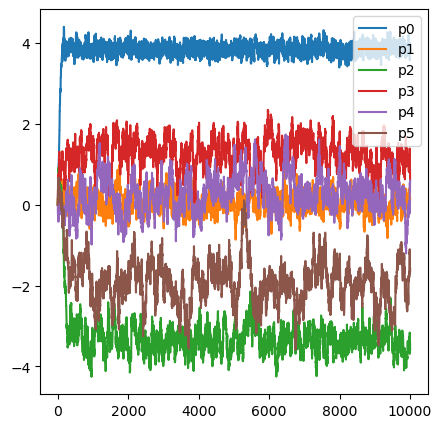

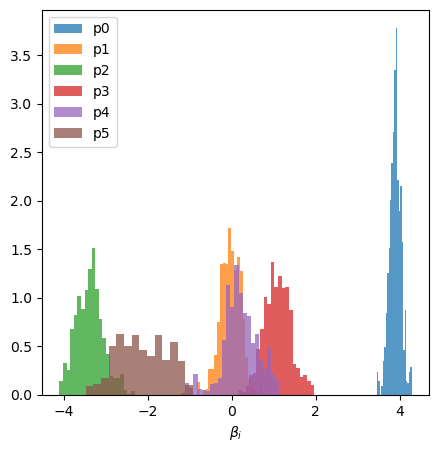

final parameters:   [ 3.89383844 -0.02477462 -3.37747309  1.0869945   0.20008251 -2.12484084]
parameter s.e:      [0.13666106 0.24354942 0.31779205 0.3139703  0.42864747 0.58745531]


In [8]:
xhi_0 = lambda params: xhi(x,y,params)
params,a = MCMC([np.array([0.0,0.0,0.0,0.0,0.0,0.0])],xhi_0,len(y),max=10000)
p_array = np.vstack(params[-1000:])

# Plot the parameter trajectory
plt.figure(figsize=(5,5))
for i in range(len(params[-1])):
  plt.plot(range(len(params)),[ _[i] for _ in params ],label='p{}'.format(i))
plt.legend()

# Plot the parameter histograms
plt.figure(figsize=(5,5))
for i in range(len(params[-1])):
  plt.hist(p_array[:,i],'auto', density=True, alpha=0.75,label="p{}".format(i))
plt.legend()
plt.xlabel(r"$\beta_i$")
plt.show()

# Print diagnostics
p_mean = np.mean(p_array,axis=0)
e = np.std(p_array,axis=0)
print("final parameters:   {}".format(p_mean))
print("parameter s.e:      {}".format(e))

The algorithm returns a trajectory of $\beta$, starting with our initial guess ([0,0,0,0,0,0]). Plotting the trajectory, you can see that the burn in period terminates after \~500 cycles, after which the parameters settle into a local minimum. To be conservative we only keep the last 1000 sets of parameters as reflecting the posterior distribution. It is common practice to modify the algorithm to keep the best set of parameters in the trajectory (based on $\chi^2$). 

Using the last 1000 models we can plot the predictions from the average model and the prediction bounds similar to how we did for the bootstrap:

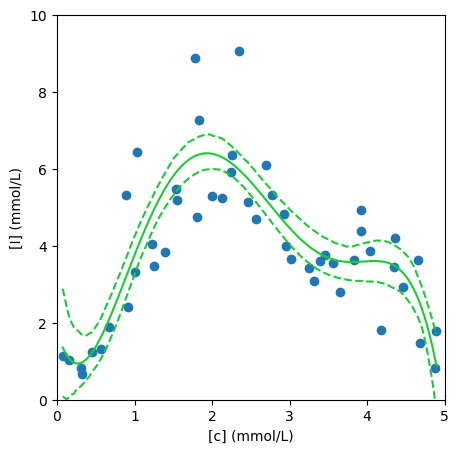

final parameters:   [ 3.89383844 -0.02477462 -3.37747309  1.0869945   0.20008251 -2.12484084]
parameter s.e:      [0.13666106 0.24354942 0.31779205 0.3139703  0.42864747 0.58745531]


In [9]:
y_p = np.array([np.polynomial.legendre.legval((x_plot-2.5)/2.5,_) for _ in p_array ]) # holds the predictions for each model

# Plot average model and prediction intervals
y_sorted = np.sort(y_p,axis=0)
plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.plot(x_plot,np.polynomial.legendre.legval((x_plot-2.5)/2.5,np.mean(p_array,axis=0)),color=(0.1,0.8,0.2))
plt.plot(x_plot,y_sorted[49,:],linestyle='--',color=(0.1,0.8,0.2)) # 5% for 10000 models
plt.plot(x_plot,y_sorted[950,:],linestyle='--',color=(0.1,0.8,0.2)) # 95% for 10000 models
plt.xlabel("[c] (mmol/L)")
plt.ylabel("[I] (mmol/L)")
plt.ylim([0,10])
plt.xlim([0,5])
plt.show()

# Print diagnostics
print("final parameters:   {}".format(np.mean(p_array,axis=0)))
print("parameter s.e:      {}".format(np.std(p_array,axis=0)))